In [1]:
import numpy as np
#import cupy as cp
#import sys
import time

from csr2d.beam_conversion import particle_group_to_bmad, bmad_to_particle_group
from pmd_beamphysics.plot import marginal_plot, density_plot
from csr2d.simple_track import track_a_bend, track_a_drift
from gathering.csr_kick import calc_csr_kick

import matplotlib.pyplot as plt

import scipy.constants
c_light = scipy.constants.c
e_charge = scipy.constants.e

In [2]:
# fix random seed 
np.random.seed(0)

# Define a fake Gaussian beam 

# Number of macro particles
Np = 100000

sigma = 10E-6 
beam = np.random.normal(0, sigma , size=(6, Np))

beta_x = 5
emit_x = 0.5 * 1E-6 / 10000
sigma_x = np.sqrt(emit_x * beta_x)
sigma_xp = np.sqrt(emit_x**2 / sigma_x**2)  # to be fixed if <x xp> is nonzero

beam[0] = np.random.normal(0, sigma_x , size=(1, Np))
beam[1] = np.random.normal(0, sigma_xp , size=(1, Np))

#beam[0] = np.ones(Np)*1E-12
#beam[1] = np.ones(Np)*1E-12

beam[5] = np.zeros(Np)    # turn off initial pz

Q = e_charge * 1e9

charges = np.ones(Np)*Q/Np

gamma = 10000
beta = (1-1/gamma**2)**(1/2)

rho = 5

mc2 = 510998.950
P0c = gamma * beta * mc2  # in eV

# overtaking distance ( for Tao )
L0 = (24*sigma*rho**2)**(1/3)

# Characteristic wake in eV/m from Chris's paper
W0 = 1e9* 2.8179403227E-15 * 510998.950 *(sigma/rho)**(2/3) / sigma**2

In [8]:
# Introduce dispersion
eta =   0.02497917
etap = -0.09983342
beam[0] = beam[0] + eta  * beam[5]
beam[1] = beam[1] + etap * beam[5]

In [25]:
# Check beam optics
P = bmad_to_particle_group(beam, p0c = P0c, t_ref = 0, charges = charges, verbose=False)
P.twiss()

{'alpha_x': -0.0013381246345749423,
 'beta_x': 5.021209291110626,
 'gamma_x': 0.19915556843008034,
 'emit_x': 4.998420472050329e-11,
 'eta_x': -21237214.43084825,
 'etap_x': -11897458.456414236,
 'norm_emit_x': 4.998420447058229e-07}

In [23]:
P.t

array([-1.05024267e-14, -5.34014154e-14, -1.66230241e-14, ...,
        6.01197601e-15,  9.49211349e-14,  1.42623400e-14])

In [10]:
# Compare two emittances
print(P.twiss()['norm_emit_x'])  # projected
print(P.norm_emit_x)

5.001602130042644e-07
5.001602132018554e-07


In [11]:
def projected_emit_x(beam):
    SS = np.cov(beam)
    s00 = SS[0][0] - SS[0][5]*SS[0][5] / SS[5][5]
    s01 = SS[0][1] - SS[0][5]*SS[1][5] / SS[5][5]
    s11 = SS[1][1] - SS[1][5]*SS[1][5] / SS[5][5]

    return np.sqrt(s00*s11 - s01**2)

In [ ]:
# Save the initial beam to run in Bmad
#P.write_bmad('Yunhai_2dcsr_beam_Np200k.txt',p0c = P0c, t_ref = 0)

# Main Loop

In [3]:
# save the initial status

Plist = []       # To save the beam at each step
all_output = []  # To save the wake and grid at each step
slist = [0]      # To save the s position at each step
s = 0

P = bmad_to_particle_group(beam, p0c = P0c, t_ref = 0, charges = charges, verbose=False)
Plist.append(P)


ds = 0.01

for i in range(1):
    print("Running", i+1 , "th loop...") 

    ## track through a bend of length ds/2
    beam = track_a_bend(beam, P0c = P0c, L=ds/2, theta = ds/2/rho, g_err=0)

    
    ## Calculate CSR kicks to xp and delta
    ####===================================
    
    sigma_x = np.std(beam[0])
    sigma_z = np.std(beam[4])
  
    output = calc_csr_kick(beam, charges, Np, 10000, rho, Nz=500, sigma_z=sigma_z, Nx=500, sigma_x=sigma_x, verbose=True)
    all_output.append(output)
    
    delta_kick = output['delta_kick'] 
    beam[5] = beam[5] + delta_kick * ds
    
    #xp_kick = output['xp_kick'] 
    #beam[1] = beam[1] + xp_kick * ds
    
    ####====================================

    ## track through a bend of length ds/2
    beam = track_a_bend(beam, P0c = P0c, L=ds/2, theta = ds/2/rho, g_err=0)
    
    # save the beam
    P = bmad_to_particle_group(beam, p0c = P0c, t_ref = 0, charges = charges, verbose=False)
    Plist.append(P)
    
    # save the s
    s += ds
    slist.append(s)

Running 1 th loop...
Depositting particles takes: 0.5221009254455566 s
Computing potential grids take: 1.4286117553710938 s


In [4]:
import matplotlib
%matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [12]:
W=output['Ws_grid']

zvec = output['zvec']

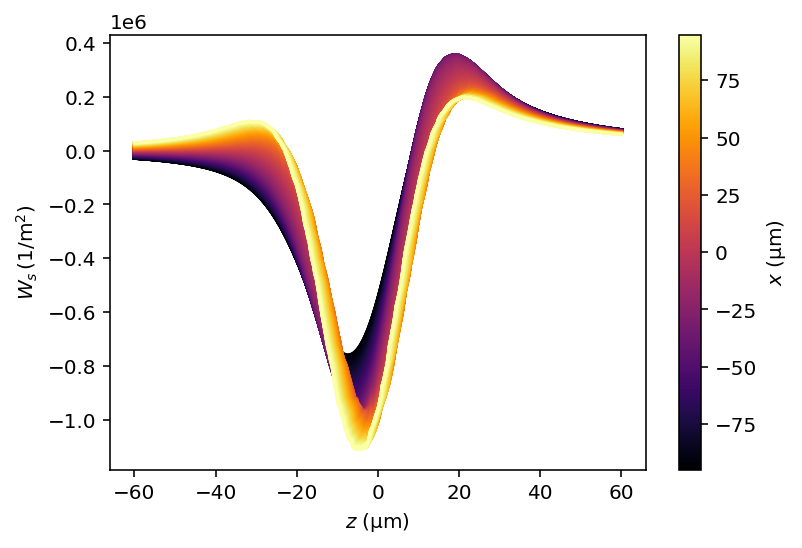

In [43]:
W=output['Ws_grid'].T 
zvec = output['zvec'] *1e6

cmap = matplotlib.cm.get_cmap('inferno')
colors = cmap(np.linspace(0,1,len(W)))
fig, ax = plt.subplots(figsize=(6,4))
for i, ws in enumerate(W):
    ax.plot(zvec, ws, color=colors[i])
    
xvec = output['xvec'] *1e6
xmin = min(xvec) 
xmax = max(xvec)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=xmin, vmax=xmax))
cbar = fig.colorbar(sm)  

cbar.set_label('$x$'+' (µm)')
#ax.set_title('2D CSR wake')
ax.set_xlabel('$z$'+' (µm)')
ax.set_ylabel(r'$W_s\, (1/\mathrm{m}^2)$')
plt.savefig('Ws.png', dpi=150)

In [16]:
KEY = 'Wx_grid'
LABEL = r'$W_x (1/\mathrm{m}^2)$'
W = output[KEY] / 1e6
charge_grid = output['charge_grid']
zvec = output['zvec'] *1e6
xvec = output['xvec'] *1e6
xmin = min(xvec) 
xmax = max(xvec)
zmin = min(zvec) 
zmax = max(zvec)

Z, X = np.meshgrid(zvec, xvec, indexing='ij')
Z.shape

(500, 500)

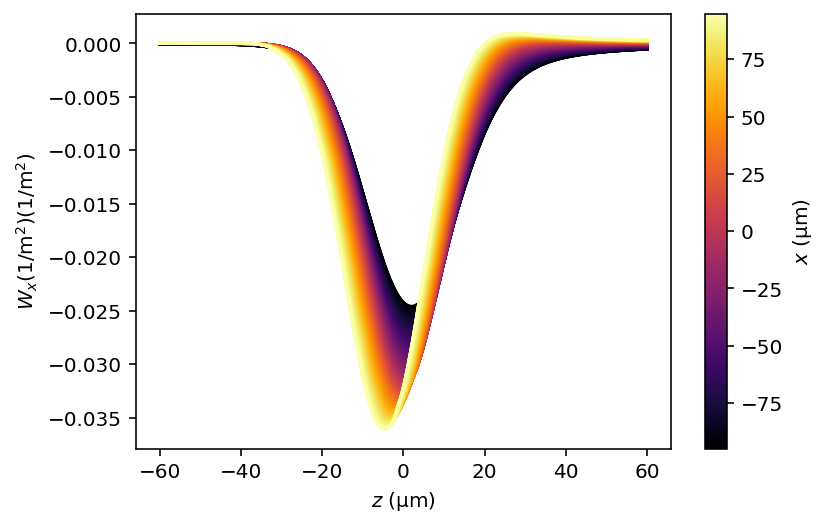

In [17]:
cmap = matplotlib.cm.get_cmap('inferno')
colors = cmap(np.linspace(0,1,len(W.T)))
fig, ax = plt.subplots(figsize=(6,4))
for i, ws in enumerate(W.T):
    ax.plot(zvec, ws, color=colors[i])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=xmin, vmax=xmax))
cbar = fig.colorbar(sm)    
cbar.set_label('$x$'+' (µm)')
#ax.set_title('2D CSR wake')
ax.set_xlabel('$z$'+' (µm)')
ax.set_ylabel(LABEL+ r'$(1/\mathrm{m}^2)$')
plt.savefig(f'{KEY}.png', dpi=150)

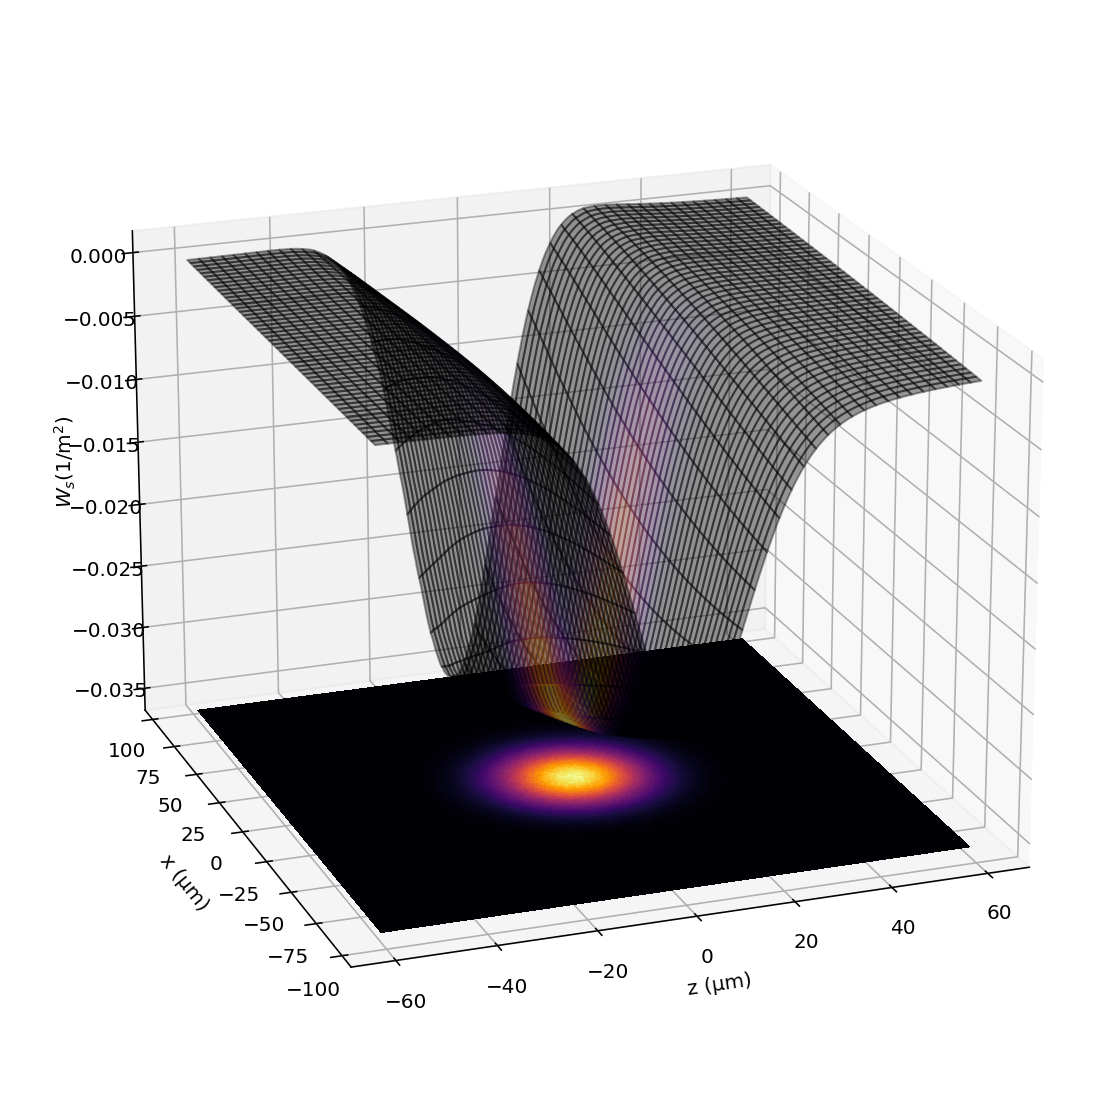

In [15]:
from mpl_toolkits.mplot3d import Axes3D
cmap = matplotlib.cm.get_cmap('inferno')
cdata = output['charge_grid']
colors = cmap(cdata/cdata.max())
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Z, X, W, alpha=0.4, facecolors=colors)
#ax.contourf(Z, X, W, zdir='y', offset=Z.min(), cmap=matplotlib.cm.coolwarm)
ax.contourf(Z, X, charge_grid, 100, zdir='z', offset=W.min(), extent=[zmin, zmax, xmin, xmax], cmap=cmap)
#ax.set_title('2D CSR wake')
ax.set_xlabel('z (µm)')
ax.set_ylabel('x (µm)')
ax.zaxis.set_rotate_label(False)
ax.set_zlabel(LABEL, rotation=90)
ax.view_init(20, 250)
plt.savefig(f'{KEY}_3d.png', dpi=150)

## Quick plots ( at the final tracking step )

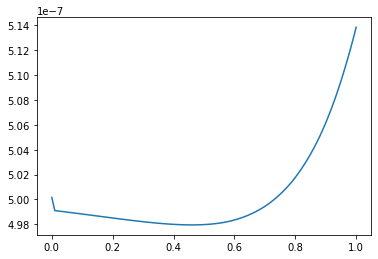

In [13]:
plt.plot(slist, [P.twiss()['norm_emit_x'] for P in Plist])

In [23]:
# Kick factor from Yunhai's paper
r_e = 2.8179403227e-15 
Nb =  1e9
gamma=10000
kick_factor = r_e*Nb/gamma   

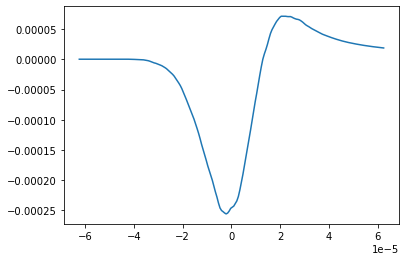

In [92]:
plt.plot(output['zvec'],output['Ws_grid'][:,100]*kick_factor)

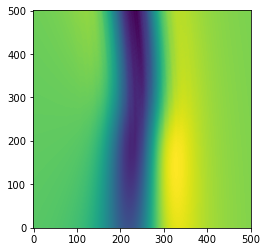

In [53]:
plt.imshow(all_output[0]['Ws_grid'].T, origin='lower')

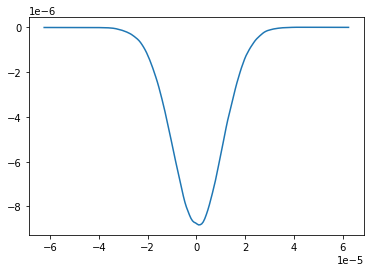

In [91]:
plt.plot(output['zvec'],output['Wx_grid'][:,100]*kick_factor)

## Saving files for analysis

In [13]:
temp = np.array([all_output[i]['Ws_grid'] for i in range(len(all_output))])
                 
np.save('Ws_grid_0.5m_50steps_Np1M_Nb500.npy', temp, allow_pickle=True)

NameError: name 'all_output' is not defined

In [50]:
temp = np.array([all_output[i]['Wx_grid'] for i in range(len(all_output))])
np.save( 'Wx_grid_0.5m_50steps_Np1M_Nb500.npy', temp, allow_pickle=True)

In [51]:
temp = np.array([all_output[i]['zvec'] for i in range(len(all_output))])
np.save( 'zvec_0.5m_50steps_Np1M_Nb500.npy', temp, allow_pickle=True)

In [52]:
temp = np.array([all_output[i]['xvec'] for i in range(len(all_output))])
np.save( 'xvec_0.5m_50steps_Np1M_Nb500.npy', temp, allow_pickle=True)

In [105]:
np.save( 'slist_0.5m_50steps.npy', slist, allow_pickle=True)

In [ ]:
# This might kill memory to save all P
#np.save( 'Plist_1m_100steps_Np200k_Nb200.npy', Plist, allow_pickle=True)

## Plot projected emittance

In [26]:
beamlist = [particle_group_to_bmad(P,p0c = P0c)[0] for P in Plist] 
pro_emit_x_list = [projected_emit_x(b)*gamma for b in beamlist]

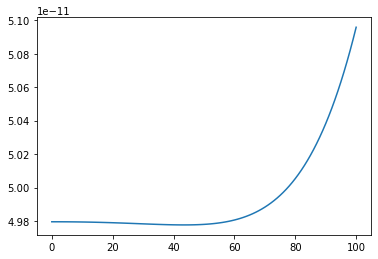

In [14]:
tao_pro_emit_x_list = np.loadtxt('/global/cfs/cdirs/m669/wlou1991/bmad_distributions/bmad_svn/tao/examples/simple_bend/pro_emit_x.dat')
plt.plot(tao_pro_emit_x_list)

In [ ]:
plt.plot(pro_emit_x_list)

In [ ]:
marginal_plot(Plist[100], 't', 'energy', bins=250)

In [ ]:
marginal_plot(Plist[100], 'x', 'xp', bins=250)

In [ ]:
from h5py import File
from pmd_beamphysics import ParticleGroup, particle_paths

In [28]:
Plist[0].write_bmad('Yunhai_2dcsr_beam_Np1M.txt',p0c = P0c, t_ref = 0)

In [26]:
Plist[0].twiss()['norm_emit_x']

5.001602130042644e-07

In [29]:
# Import beam_dump.h5, which has many beams in one h5 file

from pmd_beamphysics import ParticleGroup, particle_paths
from h5py import File
filename = '/global/cfs/cdirs/m669/wlou1991/bmad_distributions/bmad_svn/tao/examples/simple_bend/beam_dump_Np1M_Nb200.h5'
with File(filename, 'r') as h5:
    ppaths = particle_paths(h5)
    PG = [ParticleGroup(h5[g]) for g in ppaths]
    
def get_stat(key):
    return [P[key] for P in PG]


In [31]:
tao_pro_emit_x_list = [P.twiss()['norm_emit_x'] for P in PG]
pro_emit_x_list = [P.twiss()['norm_emit_x'] for P in Plist]

In [55]:
#np.save('pro_emit_x_100steps_Np1M_Nb500.npy', pro_emit_x_list, allow_pickle=True)
np.savetxt('pro_emit_x_100steps_Np1M_Nb500.txt', pro_emit_x_list)

In [32]:
lala = get_stat('norm_emit_x')  # Tao
kaka = [P['norm_emit_x'] for P in Plist]

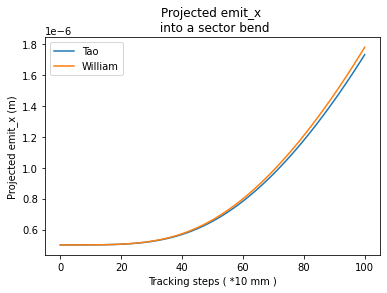

In [33]:
plt.plot(lala, label = 'Tao')
plt.plot(kaka, label = 'William')

plt.xlabel('Tracking steps ( *10 mm )')
plt.ylabel('Projected emit_x (m)')
plt.title('Projected emit_x \n into a sector bend')
plt.legend()

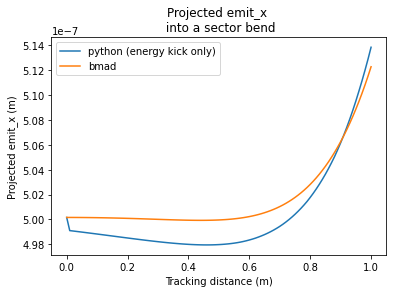

In [48]:
plt.plot(slist, pro_emit_x_list, label = 'python (energy kick only)')
plt.plot(slist, tao_pro_emit_x_list, label = 'bmad')

plt.xlabel('Tracking distance (m)')
plt.ylabel('Projected emit_x (m)')
plt.title('Projected emit_x \n into a sector bend')
plt.legend()

In [38]:
len(Plist)

101

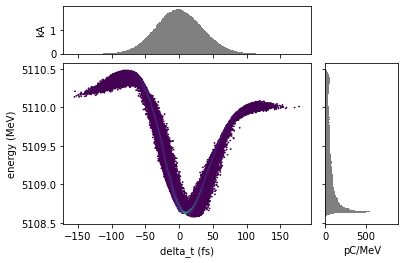

In [47]:
Plist[-1].plot('delta_t', 'energy', bins=250)

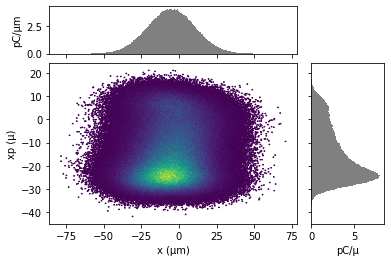

In [41]:
Plist[-1].plot('x', 'xp', bins=250)

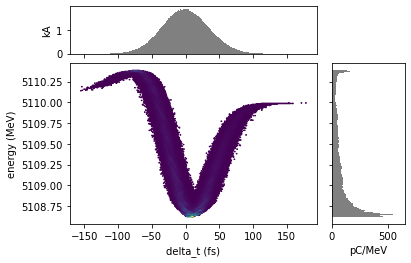

In [46]:
PG[-1].plot('delta_t', 'energy', bins=250)

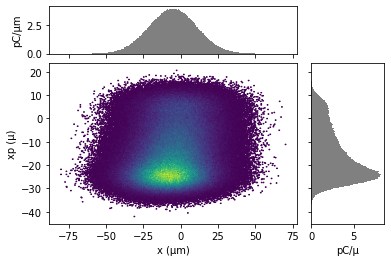

In [45]:
PG[-1].plot('x', 'xp', bins=250)

In [ ]:
H5FILE  = '/global/cfs/cdirs/m669/wlou1991/bmad_distributions/bmad_svn/tao/examples/simple_bend/beam_END_1m_csron_zero_pz.hdf5'

# Load
h5 = File(H5FILE, 'r')
ppaths = particle_paths(h5)
ph5 = h5[ppaths[0]]

Ptao = ParticleGroup(ph5)

In [ ]:
marginal_plot(Ptao, 't', 'energy', bins=250)

In [ ]:
marginal_plot(Ptao, 'x', 'xp', bins=250)

In [ ]:
gamma

In [ ]:
twiss_list = [P.twiss('x') for P in Plist]

In [ ]:
plt.plot([t['norm_emit_x'] for t in twiss_list])

In [ ]:
plt.scatter(np.arange(len(data_vec4))*10, data_vec4) 
plt.xlabel('Tracking distance (mm)')
plt.ylabel('P.twiss()["norm_emit_x"] (m)')
plt.title('P.twiss()["norm_emit_x"]  \n into a sector bend')

In [ ]:
P.twiss(plane = 'x')

In [ ]:
P.norm_emit_x

In [ ]:
vec2 = np.append(vec2, data_vec[-1])  

In [ ]:
plt.scatter(np.arange(len(data_vec4))*10, data_vec4) 
plt.xlabel('Tracking distance (mm)')
plt.ylabel('P.twiss()["norm_emit_x"] (m)')
plt.title('P.twiss()["norm_emit_x"]  \n into a sector bend')

In [ ]:
plt.scatter(np.arange(len(data_vec2))*10, data_vec2) 
plt.xlabel('Tracking distance (mm)')
plt.ylabel('beta_x (m)')
plt.title('beta_x \n into a sector bend')

In [ ]:
plt.scatter(np.arange(len(data_vec3)-1)*10, data_vec3[1:]) 
plt.xlabel('Tracking distance (mm)')
plt.ylabel('eta_x (m)')
plt.title('eta_x \n into a sector bend')

In [ ]:
plt.scatter(np.arange(len(data_vec))*10, data_vec) 
plt.xlabel('Tracking distance (mm)')
plt.ylabel('norm_emit_x (m)')
plt.title('norm_emit_x \n into a sector bend')

In [ ]:
marginal_plot(P, 't', 'energy', bins=250)

In [ ]:
marginal_plot(P, 'x', 'xp', bins=250)

# Save and load multiple data for analysis

In [ ]:
# Name the file properly to avoid over-writting
np.savetxt("twiss_emitx_xp_kick_only_ds10mm_rho5m_beta5m_50steps.txt", data_vec4)

In [ ]:
d1 = np.loadtxt("emit_growth_no_csr_20steps.txt")
d2 = np.loadtxt("emit_growth_delta_kick_only_20steps.txt")
d3 = np.loadtxt("emit_growth_xp_kick_only_20steps.txt")
d4 = np.loadtxt("emit_growth_2d_csr_on_20steps.txt")

In [ ]:
plt.scatter(np.arange(20), d1, label='no csr')
plt.scatter(np.arange(20), d2, label='delta kick only')
plt.scatter(np.arange(20), d3, label='xp kick only')
plt.scatter(np.arange(20), d4, label='both kicks on')

plt.xlabel('Tracking distance (mm)')
plt.ylabel('norm_emit_x (m)')
plt.legend()
plt.title('Normalized horizontal emittance growth')

In [ ]:
d1 = np.loadtxt("sigma_z_no_csr_20steps.txt")
d2 = np.loadtxt("sigma_z_delta_kick_only_20steps.txt")
d3 = np.loadtxt("sigma_z_xp_kick_only_20steps.txt")
d4 = np.loadtxt("sigma_z_2d_csr_on_20steps.txt")

In [ ]:
plt.scatter(np.arange(21), d1, label='no csr')
plt.scatter(np.arange(21), d2, label='delta kick only')
plt.scatter(np.arange(21), d3, label='xp kick only')
plt.scatter(np.arange(21), d4, label='both kicks on')

plt.xlabel('Tracking distance (mm)')
plt.ylabel('sigma_z (m)')
plt.legend()
plt.title('Bunch length')